## 1. Import libraries

In [709]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import folium
import json
import requests
import codecs

try:
  import geocoder
except:
  !pip install geocoder
  import geocoder

from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from pandas.core.common import flatten

print("Libraries imported.")

Libraries imported.


## 2. Data Preparation

In [769]:
!wget https://en.wikipedia.org/wiki/Category:Districts_of_Hanoi
print("Data downloaded successfully!")

--2020-01-21 08:21:35--  https://en.wikipedia.org/wiki/Category:Districts_of_Hanoi
Resolving en.wikipedia.org (en.wikipedia.org)... 91.198.174.192, 2620:0:862:ed1a::1
Connecting to en.wikipedia.org (en.wikipedia.org)|91.198.174.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28771 (28K) [text/html]
Saving to: ‘Category:Districts_of_Hanoi.2’

Category:Districts_ 100%[===================>]  28.10K  --.-KB/s    in 0.005s  

2020-01-21 08:21:36 (5.80 MB/s) - ‘Category:Districts_of_Hanoi.2’ saved [28771/28771]

Data downloaded successfully!


In [0]:
html = codecs.open('Category:Districts_of_Hanoi', encoding='utf-8').read()
soup = BeautifulSoup(html, 'html.parser')

In [0]:
def clean_district_name(district_name):
  if ', Hanoi' in district_name:
    district_name = district_name.replace(', Hanoi', '')
  if 'District' not in district_name:
    district_name += ' District'
  return district_name 

In [713]:
districts = [li.text.split('\n') for li in soup.find_all('ul')[0:13]]
districts = list(flatten(districts))
districts = [clean_district_name(dist) for dist in districts]

print('There are {} districts in Hanoi, VN.'.format(len(districts)))
districts

There are 30 districts in Hanoi, VN.


['Ba Đình District',
 'Ba Vì District',
 'Bắc Từ Liêm District',
 'Cầu Giấy District',
 'Chương Mỹ District',
 'Đan Phượng District',
 'Đông Anh District',
 'Đống Đa District',
 'Gia Lâm District',
 'Hà Đông District',
 'Hai Bà Trưng District',
 'Hoài Đức District',
 'Hoàn Kiếm District',
 'Hoàng Mai District',
 'Long Biên District',
 'Mê Linh District',
 'Mỹ Đức District',
 'Nam Từ Liêm District',
 'Phú Xuyên District',
 'Phúc Thọ District',
 'Quốc Oai District',
 'Sóc Sơn District',
 'Sơn Tây District',
 'Tây Hồ District',
 'Thạch Thất District',
 'Thanh Oai District',
 'Thanh Trì District',
 'Thanh Xuân District',
 'Thường Tín District',
 'Ứng Hòa District']

In [0]:
geolocator = Nominatim(user_agent='ibm-capstone')

In [0]:
districts_lat = []
districts_lng = []

In [734]:
for dist in districts:
  location = geolocator.geocode(dist)
  districts_lat.append(location.latitude)
  districts_lng.append(location.longitude)

print('{} latitudes and {} longitudes were found.'.format(len(districts_lat), len(districts_lng)))

30 latitudes and 30 longitudes were found.


In [735]:
city = 'Hanoi, VN'
hanoi_geo = geolocator.geocode(city)
hanoi_lat = hanoi_geo.latitude
hanoi_lng = hanoi_geo.longitude

print('The latitude and longitude of {} are {}, {}.'.format(city, hanoi_lat, hanoi_lng))

The latitude and longitude of Hanoi, VN are 21.0294498, 105.8544441.


In [736]:
df = pd.DataFrame(data={
    'District': districts,
    'Latitude': districts_lat,
    'Longitude': districts_lng
})
df.head()

,District,Latitude,Longitude
0,Ba Đình District,21.036305,105.828986
1,Ba Vì District,21.157242,105.376764
2,Bắc Từ Liêm District,21.071570,105.760472
3,Cầu Giấy District,21.036308,105.786075
4,Chương Mỹ District,20.878474,105.649250


In [0]:
df.to_csv('Hanoi_Districts_data.csv', index=False)

## 3. Get venues of each district within a radius of 10km 

In [0]:
# Foursquare cresentials and version
CLIENT_ID = '30WAK2CZFZ44DKIFAWKLBHIVQ0BQUE3KIU5ZTA0VCIPMC0DU'
CLIENT_SECRET = 'VPQMF0VAW0PENNH3VU25RI52BD4DTDGPKMG22DKNZ0MKGROW'
VERSION = '20200101'
SECTION = 'arts'
LIMIT = 50
RADIUS = 10000

In [0]:
def getNearbyVenues(districts, latitudes, longitudes):
    
    venues_list=[]
    for district, lat, lng in zip(districts, latitudes, longitudes):
        print(district)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            SECTION)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            district,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
                            'District Latitude', 
                            'District Longitude', 
                            'Venue', 
                            'Venue Latitude', 
                            'Venue Longitude', 
                            'Venue Category']
              
    return(nearby_venues)

In [739]:
hanoi_venues = getNearbyVenues(districts=df['District'],
                              latitudes=df['Latitude'],
                              longitudes=df['Longitude'])

Ba Đình District
Ba Vì District
Bắc Từ Liêm District
Cầu Giấy District
Chương Mỹ District
Đan Phượng District
Đông Anh District
Đống Đa District
Gia Lâm District
Hà Đông District
Hai Bà Trưng District
Hoài Đức District
Hoàn Kiếm District
Hoàng Mai District
Long Biên District
Mê Linh District
Mỹ Đức District
Nam Từ Liêm District
Phú Xuyên District
Phúc Thọ District
Quốc Oai District
Sóc Sơn District
Sơn Tây District
Tây Hồ District
Thạch Thất District
Thanh Oai District
Thanh Trì District
Thanh Xuân District
Thường Tín District
Ứng Hòa District


In [740]:
hanoi_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ba Đình District,21.036305,105.828986,Café Nhà Sàn,21.043893,105.807144,Art Gallery
1,Ba Đình District,21.036305,105.828986,Bảo Tàng Dân Tộc Học Việt Nam (Vietnam Museum ...,21.040516,105.798117,Museum
2,Ba Đình District,21.036305,105.828986,BHD Star Cineplex Vincom Phạm Ngọc Thạch,21.006541,105.831992,Movie Theater
3,Ba Đình District,21.036305,105.828986,CGV Cinemas Vincom Nguyễn Chí Thanh,21.023058,105.809507,Multiplex
4,Ba Đình District,21.036305,105.828986,Bình Minh Jazz Club,21.024020,105.858175,Jazz Club


In [741]:
hanoi_venues.shape

(612, 7)

## 4. Data Wrangling

In [742]:
hanoi_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 7 columns):
District              612 non-null object
District Latitude     612 non-null float64
District Longitude    612 non-null float64
Venue                 612 non-null object
Venue Latitude        612 non-null float64
Venue Longitude       612 non-null float64
Venue Category        612 non-null object
dtypes: float64(4), object(3)
memory usage: 33.6+ KB


In [743]:
hanoi_venues['Venue Category'].unique()

array(['Art Gallery', 'Museum', 'Movie Theater', 'Multiplex', 'Jazz Club',
       'Music Venue', 'Opera House', 'Art Museum', 'History Museum',
       'Rock Club', 'Theater', 'Concert Hall', 'Memorial Site',
       'Performing Arts Venue', 'Public Art', 'Dance Studio',
       'Zoo Exhibit', 'Amphitheater'], dtype=object)

## 5. Data Analysis

In [744]:
venues_by_dist = hanoi_venues.groupby('District').count()[['Venue']]
venues_by_dist

,Venue
District,
Ba Đình District,50
Bắc Từ Liêm District,26
Chương Mỹ District,3
Cầu Giấy District,50
Gia Lâm District,1
Hai Bà Trưng District,50
Hoài Đức District,9
Hoàn Kiếm District,50
Hoàng Mai District,50


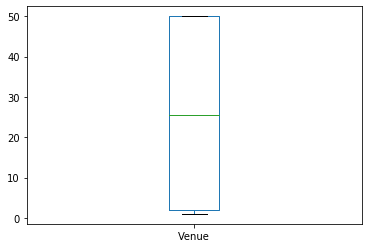

In [745]:
venues_by_dist.plot.box()

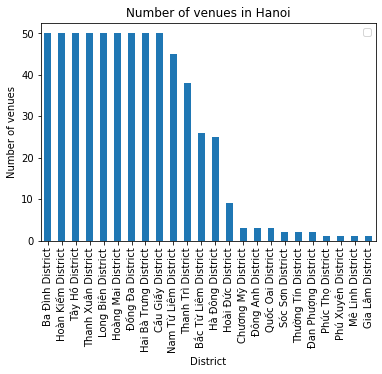

In [746]:
venues_by_dist.sort_values(by='Venue', ascending=False).plot.bar()
plt.xlabel('District')
plt.ylabel('Number of venues')
plt.legend('')
plt.title('Number of venues in Hanoi')
plt.show()

In [747]:
venues_by_category = hanoi_venues.groupby('Venue Category').count()[['Venue']]
venues_by_category

,Venue
Venue Category,
Amphitheater,6
Art Gallery,46
Art Museum,31
Concert Hall,23
Dance Studio,17
History Museum,107
Jazz Club,10
Memorial Site,7
Movie Theater,42


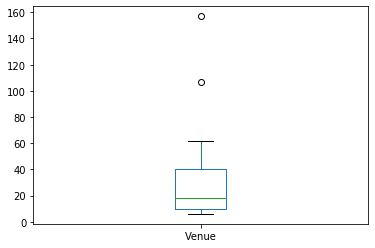

In [748]:
venues_by_category.plot.box()

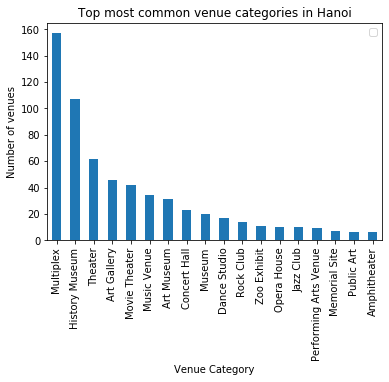

In [767]:
venues_by_category.sort_values(by='Venue', ascending=False).plot.bar()
plt.xlabel('Venue Category')
plt.ylabel('Number of venues')
plt.legend('')
plt.title('Top most common venue categories in Hanoi')
plt.show()

In [750]:
print('There are {} unique values in Hanoi Venue Category'.format(len(hanoi_venues['Venue Category'].unique())))
hanoi_venues['Venue Category'].unique()

There are 18 unique values in Hanoi Venue Category


array(['Art Gallery', 'Museum', 'Movie Theater', 'Multiplex', 'Jazz Club',
       'Music Venue', 'Opera House', 'Art Museum', 'History Museum',
       'Rock Club', 'Theater', 'Concert Hall', 'Memorial Site',
       'Performing Arts Venue', 'Public Art', 'Dance Studio',
       'Zoo Exhibit', 'Amphitheater'], dtype=object)

In [751]:
# one hot encoding
hanoi_onehot = pd.get_dummies(hanoi_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to dataframe
hanoi_onehot['District'] = hanoi_venues[['District']]

# move neighborhood column to the first column
fixed_columns = [hanoi_onehot.columns[-1]] + list(hanoi_onehot.columns[:-1])
hanoi_onehot = hanoi_onehot[fixed_columns]

hanoi_onehot.head()

,District,Amphitheater,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Memorial Site,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue,Public Art,Rock Club,Theater,Zoo Exhibit
0,Ba Đình District,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ba Đình District,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Ba Đình District,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Ba Đình District,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Ba Đình District,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [752]:
hanoi_onehot.shape

(612, 19)

In [753]:
hanoi_grouped = hanoi_onehot.groupby('District').mean().reset_index()
hanoi_grouped

,District,Amphitheater,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Memorial Site,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue,Public Art,Rock Club,Theater,Zoo Exhibit
0,Ba Đình District,0.000000,0.060000,0.040000,0.040000,0.020000,0.180000,0.020000,0.020000,0.060000,0.240000,0.040000,0.060000,0.020000,0.020000,0.02,0.020000,0.120000,0.020000
1,Bắc Từ Liêm District,0.000000,0.076923,0.115385,0.038462,0.000000,0.153846,0.000000,0.038462,0.038462,0.384615,0.038462,0.038462,0.000000,0.000000,0.00,0.038462,0.038462,0.000000
2,Chương Mỹ District,0.000000,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
3,Cầu Giấy District,0.000000,0.080000,0.060000,0.020000,0.020000,0.200000,0.020000,0.020000,0.060000,0.260000,0.040000,0.040000,0.020000,0.020000,0.00,0.020000,0.100000,0.020000
4,Gia Lâm District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
5,Hai Bà Trưng District,0.020000,0.080000,0.040000,0.040000,0.020000,0.180000,0.020000,0.000000,0.060000,0.220000,0.040000,0.060000,0.020000,0.020000,0.02,0.020000,0.120000,0.020000
6,Hoài Đức District,0.000000,0.000000,0.111111,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
7,Hoàn Kiếm District,0.000000,0.060000,0.040000,0.040000,0.020000,0.180000,0.020000,0.020000,0.080000,0.220000,0.040000,0.060000,0.020000,0.020000,0.02,0.020000,0.120000,0.020000
8,Hoàng Mai District,0.020000,0.080000,0.040000,0.040000,0.020000,0.180000,0.020000,0.000000,0.060000,0.220000,0.040000,0.060000,0.020000,0.020000,0.02,0.020000,0.120000,0.020000
9,Hà Đông District,0.040000,0.040000,0.040000,0.040000,0.080000,0.080000,0.000000,0.000000,0.120000,0.440000,0.000000,0.000000,0.000000,0.000000,0.00,0.040000,0.040000,0.040000


In [754]:
hanoi_grouped.shape

(24, 19)

In [755]:
# Print top 5 most common venues of each district
num_top_venues = 5

for dist in hanoi_grouped['District']:
    print('----'+dist+'----')
    # get a dataframe of venues according to neigborhood and transpose it 
    temp = hanoi_grouped[hanoi_grouped['District'] == dist].T.reset_index()
    
    # update meaningful column names
    temp.columns = ['Venue Category', 'Frequency']
    
    # remove the first row of the dataframe (the previous 'District' column)
    temp = temp.iloc[1:]
    
    # convert 'freq' column to type float
    temp['Frequency'] = temp['Frequency'].astype(float)
    
    # round the 'freq' column to 2 digit
    temp = temp.round({'Frequency': 2})
    
    # sort the dataframe desceningly
    temp.sort_values(by='Frequency', ascending=False, inplace=True)
    
    # reset and drop index
    temp = temp.reset_index(drop=True)
    
    print(temp[:5])
    print('')

----Ba Đình District----
   Venue Category  Frequency
0       Multiplex       0.24
1  History Museum       0.18
2         Theater       0.12
3   Movie Theater       0.06
4     Art Gallery       0.06

----Bắc Từ Liêm District----
   Venue Category  Frequency
0       Multiplex       0.38
1  History Museum       0.15
2      Art Museum       0.12
3     Art Gallery       0.08
4    Concert Hall       0.04

----Chương Mỹ District----
   Venue Category  Frequency
0    Dance Studio       0.33
1  History Museum       0.33
2     Art Gallery       0.33
3    Amphitheater       0.00
4     Music Venue       0.00

----Cầu Giấy District----
   Venue Category  Frequency
0       Multiplex       0.26
1  History Museum       0.20
2         Theater       0.10
3     Art Gallery       0.08
4      Art Museum       0.06

----Gia Lâm District----
  Venue Category  Frequency
0      Multiplex        1.0
1    Art Gallery        0.0
2        Theater        0.0
3      Rock Club        0.0
4     Public Art        0.0


In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [757]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = hanoi_grouped['District']

for ind in np.arange(hanoi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hanoi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Ba Đình District,Multiplex,History Museum,Theater,Movie Theater,Art Gallery,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
1,Bắc Từ Liêm District,Multiplex,History Museum,Art Museum,Art Gallery,Movie Theater,Rock Club,Concert Hall,Music Venue,Museum,Theater,Memorial Site,Dance Studio,Zoo Exhibit,Jazz Club,Opera House
2,Chương Mỹ District,Art Gallery,Dance Studio,History Museum,Zoo Exhibit,Theater,Art Museum,Concert Hall,Jazz Club,Memorial Site,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue
3,Cầu Giấy District,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Art Museum,Music Venue,Museum,Jazz Club,Concert Hall,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
4,Gia Lâm District,Multiplex,Zoo Exhibit,Memorial Site,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Movie Theater,Theater,Museum,Music Venue,Opera House,Performing Arts Venue
5,Hai Bà Trưng District,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Opera House,Performing Arts Venue,Public Art
6,Hoài Đức District,Multiplex,Art Museum,Dance Studio,History Museum,Zoo Exhibit,Memorial Site,Art Gallery,Concert Hall,Jazz Club,Movie Theater,Theater,Museum,Music Venue,Opera House,Performing Arts Venue
7,Hoàn Kiếm District,Multiplex,History Museum,Theater,Movie Theater,Art Gallery,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
8,Hoàng Mai District,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Opera House,Performing Arts Venue,Public Art
9,Hà Đông District,Multiplex,Movie Theater,Dance Studio,History Museum,Art Gallery,Art Museum,Concert Hall,Theater,Zoo Exhibit,Rock Club,Amphitheater,Museum,Memorial Site,Jazz Club,Music Venue


## 6. Modelling

In [758]:
# set number of clusters
kclusters = 5

hanoi_grouped_clustering = hanoi_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hanoi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 3, 2, 3, 2, 2, 2], dtype=int32)

In [0]:
# add clustering labels
try:  
  neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
  neighborhoods_venues_sorted = neighborhoods_venues_sorted
hanoi_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
hanoi_merged = hanoi_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

#hanoi_merged

In [760]:
hanoi_merged.dropna(inplace=True)
hanoi_merged

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Ba Đình District,21.036305,105.828986,2.0,Multiplex,History Museum,Theater,Movie Theater,Art Gallery,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
2,Bắc Từ Liêm District,21.071570,105.760472,2.0,Multiplex,History Museum,Art Museum,Art Gallery,Movie Theater,Rock Club,Concert Hall,Music Venue,Museum,Theater,Memorial Site,Dance Studio,Zoo Exhibit,Jazz Club,Opera House
3,Cầu Giấy District,21.036308,105.786075,2.0,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Art Museum,Music Venue,Museum,Jazz Club,Concert Hall,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
4,Chương Mỹ District,20.878474,105.649250,1.0,Art Gallery,Dance Studio,History Museum,Zoo Exhibit,Theater,Art Museum,Concert Hall,Jazz Club,Memorial Site,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue
5,Đan Phượng District,21.119627,105.678469,4.0,Movie Theater,Museum,Memorial Site,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Zoo Exhibit,Theater,Multiplex,Music Venue,Opera House,Performing Arts Venue
6,Đông Anh District,21.136736,105.846359,2.0,Rock Club,Art Gallery,Multiplex,Zoo Exhibit,Memorial Site,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Movie Theater,Theater,Museum,Music Venue,Opera House
7,Đống Đa District,21.014488,105.823588,2.0,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Art Museum,Music Venue,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Opera House,Performing Arts Venue,Rock Club
8,Gia Lâm District,21.023748,105.970415,3.0,Multiplex,Zoo Exhibit,Memorial Site,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Movie Theater,Theater,Museum,Music Venue,Opera House,Performing Arts Venue
9,Hà Đông District,20.953590,105.759971,2.0,Multiplex,Movie Theater,Dance Studio,History Museum,Art Gallery,Art Museum,Concert Hall,Theater,Zoo Exhibit,Rock Club,Amphitheater,Museum,Memorial Site,Jazz Club,Music Venue
10,Hai Bà Trưng District,21.006518,105.857671,2.0,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Opera House,Performing Arts Venue,Public Art


In [761]:
# create map
map_clusters = folium.Map(location=[hanoi_lat, hanoi_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hanoi_merged['Latitude'], hanoi_merged['Longitude'], hanoi_merged['District'], hanoi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster -1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [762]:
# Cluster 0
hanoi_merged.loc[hanoi_merged['Cluster Labels'] == 0, hanoi_merged.columns[[0] + list(range(4, hanoi_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
15,Mê Linh District,Music Venue,Zoo Exhibit,Memorial Site,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Movie Theater,Theater,Multiplex,Museum,Opera House,Performing Arts Venue
18,Phú Xuyên District,Music Venue,Zoo Exhibit,Memorial Site,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Movie Theater,Theater,Multiplex,Museum,Opera House,Performing Arts Venue


In [763]:
# Cluster 1
hanoi_merged.loc[hanoi_merged['Cluster Labels'] == 1, hanoi_merged.columns[[0] + list(range(4, hanoi_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
4,Chương Mỹ District,Art Gallery,Dance Studio,History Museum,Zoo Exhibit,Theater,Art Museum,Concert Hall,Jazz Club,Memorial Site,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue
20,Quốc Oai District,Art Gallery,Dance Studio,History Museum,Zoo Exhibit,Theater,Art Museum,Concert Hall,Jazz Club,Memorial Site,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue
21,Sóc Sơn District,Art Gallery,History Museum,Zoo Exhibit,Theater,Art Museum,Concert Hall,Dance Studio,Jazz Club,Memorial Site,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue


In [764]:
# Cluster 2
hanoi_merged.loc[hanoi_merged['Cluster Labels'] == 2, hanoi_merged.columns[[0] + list(range(4, hanoi_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Ba Đình District,Multiplex,History Museum,Theater,Movie Theater,Art Gallery,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
2,Bắc Từ Liêm District,Multiplex,History Museum,Art Museum,Art Gallery,Movie Theater,Rock Club,Concert Hall,Music Venue,Museum,Theater,Memorial Site,Dance Studio,Zoo Exhibit,Jazz Club,Opera House
3,Cầu Giấy District,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Art Museum,Music Venue,Museum,Jazz Club,Concert Hall,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
6,Đông Anh District,Rock Club,Art Gallery,Multiplex,Zoo Exhibit,Memorial Site,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Movie Theater,Theater,Museum,Music Venue,Opera House
7,Đống Đa District,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Art Museum,Music Venue,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Opera House,Performing Arts Venue,Rock Club
9,Hà Đông District,Multiplex,Movie Theater,Dance Studio,History Museum,Art Gallery,Art Museum,Concert Hall,Theater,Zoo Exhibit,Rock Club,Amphitheater,Museum,Memorial Site,Jazz Club,Music Venue
10,Hai Bà Trưng District,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Opera House,Performing Arts Venue,Public Art
12,Hoàn Kiếm District,Multiplex,History Museum,Theater,Movie Theater,Art Gallery,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Memorial Site,Opera House,Performing Arts Venue
13,Hoàng Mai District,Multiplex,History Museum,Theater,Art Gallery,Movie Theater,Music Venue,Art Museum,Concert Hall,Museum,Jazz Club,Dance Studio,Zoo Exhibit,Opera House,Performing Arts Venue,Public Art
14,Long Biên District,Multiplex,History Museum,Theater,Movie Theater,Art Gallery,Music Venue,Art Museum,Concert Hall,Jazz Club,Dance Studio,Zoo Exhibit,Memorial Site,Museum,Opera House,Performing Arts Venue


In [765]:
# Cluster 3
hanoi_merged.loc[hanoi_merged['Cluster Labels'] == 3, hanoi_merged.columns[[0] + list(range(4, hanoi_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
8,Gia Lâm District,Multiplex,Zoo Exhibit,Memorial Site,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Movie Theater,Theater,Museum,Music Venue,Opera House,Performing Arts Venue
11,Hoài Đức District,Multiplex,Art Museum,Dance Studio,History Museum,Zoo Exhibit,Memorial Site,Art Gallery,Concert Hall,Jazz Club,Movie Theater,Theater,Museum,Music Venue,Opera House,Performing Arts Venue


In [766]:
# Cluster 4
hanoi_merged.loc[hanoi_merged['Cluster Labels'] == 4, hanoi_merged.columns[[0] + list(range(4, hanoi_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
5,Đan Phượng District,Movie Theater,Museum,Memorial Site,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Zoo Exhibit,Theater,Multiplex,Music Venue,Opera House,Performing Arts Venue
19,Phúc Thọ District,Movie Theater,Theater,Art Gallery,Art Museum,Concert Hall,Dance Studio,History Museum,Jazz Club,Memorial Site,Zoo Exhibit,Multiplex,Museum,Music Venue,Opera House,Performing Arts Venue
